In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft

def filtering_func(freqs, fft, phases, f1, f2):  #passing complex numbers
    noise_fft = fft.copy()

    abs_fft = np.abs(fft)
    valid_indices = np.where((freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1))[0]

    fft_in_range = abs_fft[valid_indices]

    peak = np.max(fft_in_range)

    local_peak_indices = np.where(abs_fft[valid_indices] == peak)[0]
    general_peak_indices = valid_indices[local_peak_indices]
    
    peak_f = freqs[general_peak_indices]
    print(f"peak_f: {peak_f}")

    peak_phase = phases[general_peak_indices]
    print(f"peak_phase: {peak_phase}")

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    mask = np.ones(len(noise_fft), dtype=bool)
    mask[general_peak_indices] = False
    noise_fft[mask] = complex(0, 0)
    return noise_fft, peak_f, peak_phase

In [2]:
hour = '15.42'
day = '08082024'

In [26]:
file = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_01.csv"

df = pd.read_csv(file)
times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values

In [27]:
N = len(times)
print(f"len(times): {N}")

len(times): 62504


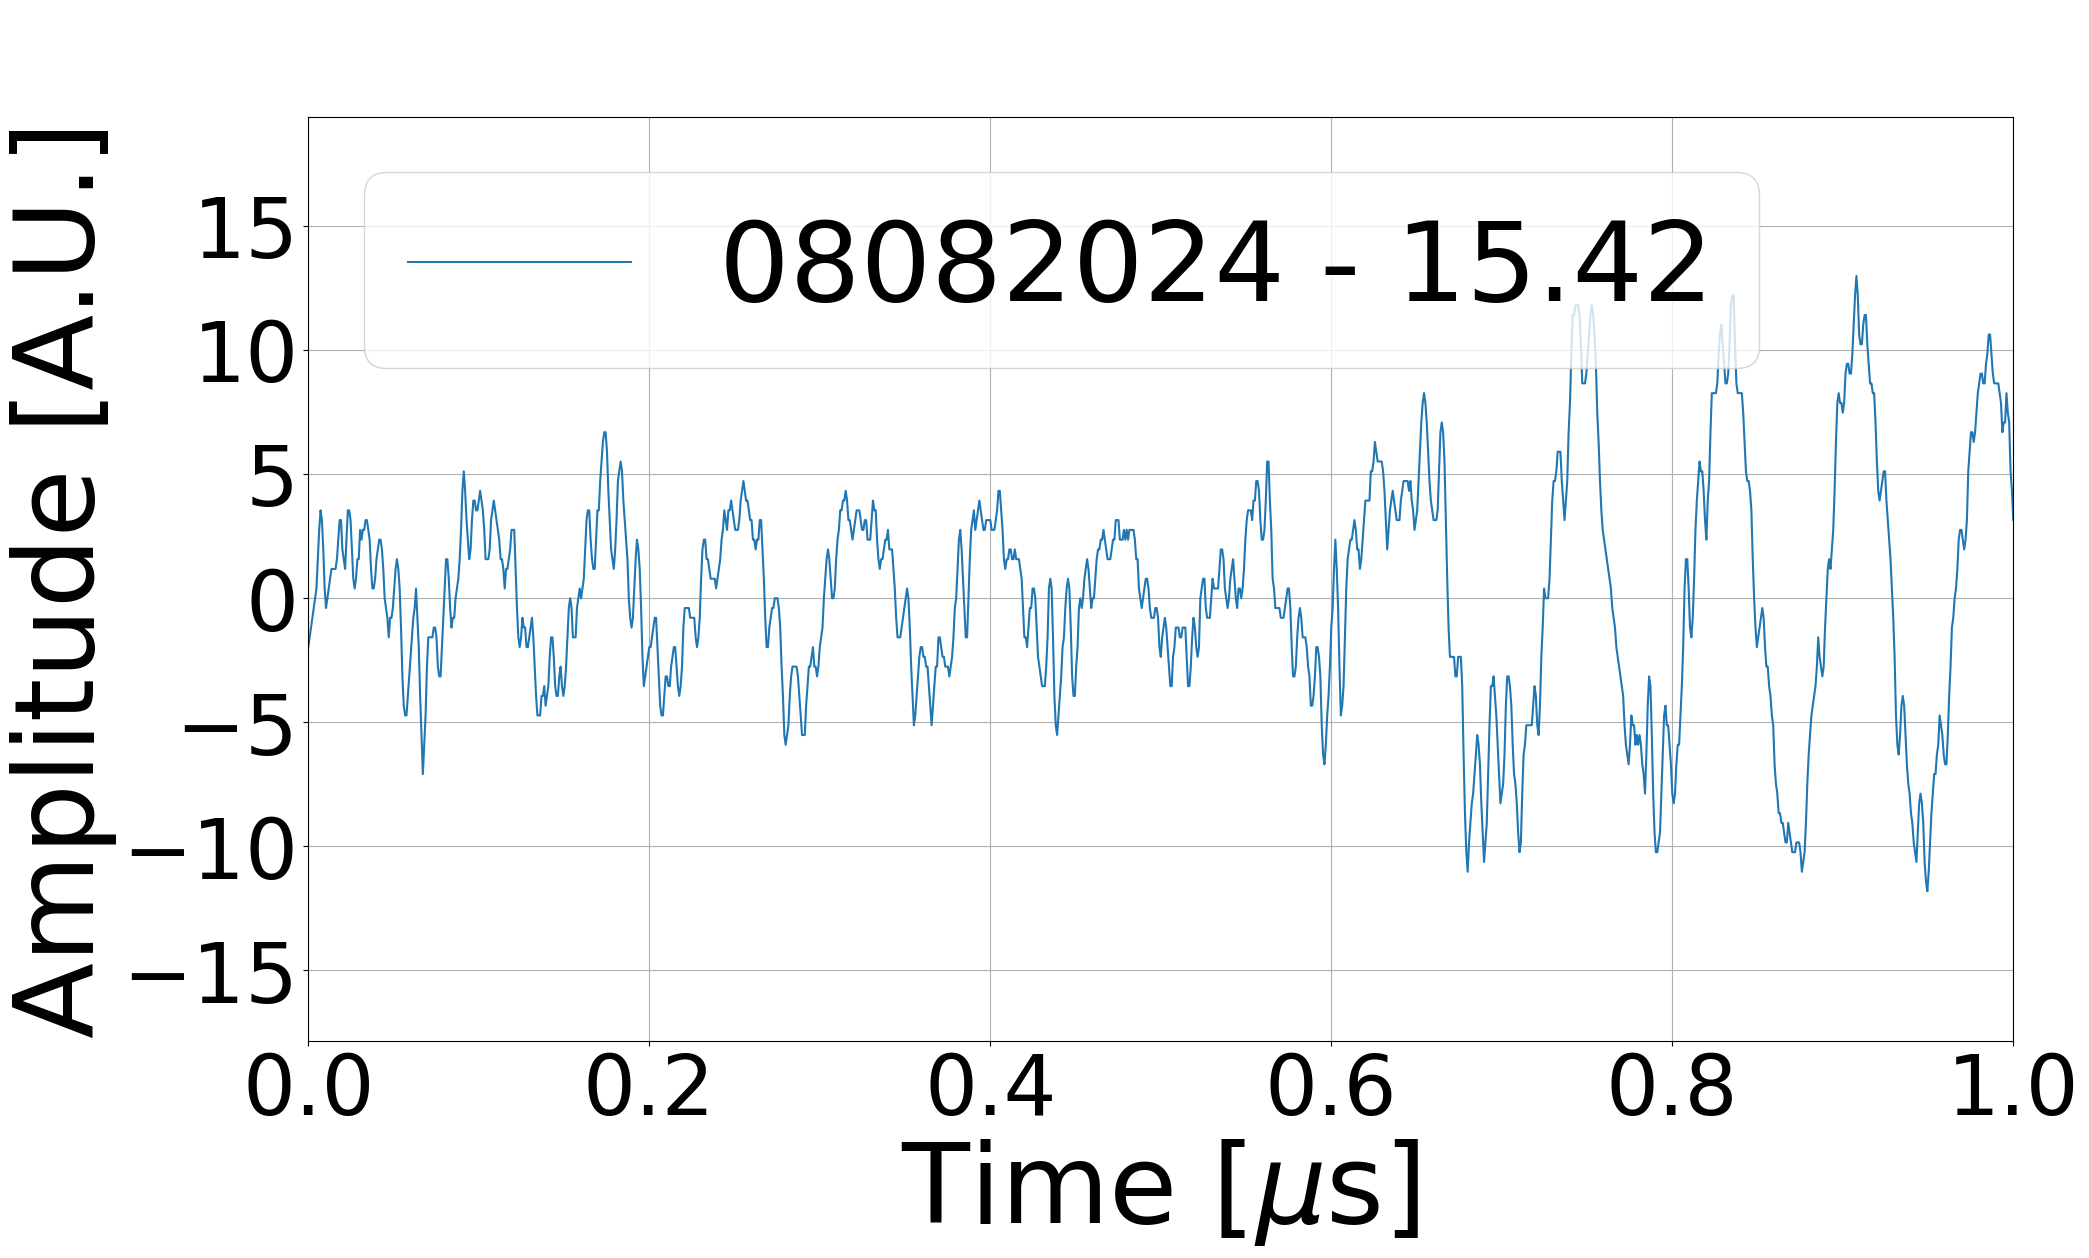

In [61]:
plt.figure(figsize = (22, 12))
plt.plot(times, amplitudes, label = '08082024 - 15.42')
plt.title(' ', fontsize = 80)
plt.xlabel(r'Time [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc = 'best', fontsize = 80)


#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## FFT

In [30]:
span = times[-1]
print(f"span: {span}") 
step = span / N
f_s = 1 / step
print(f"f_s = {f_s}")

freqs = fft.fftfreq(len(times), 1/f_s) #window lenght, sample spacing
print(f'last freq: {freqs[-1]}') ##this should be the half of f_s.
print(f"len(freqs): {len(freqs)}")
print(freqs)

span: 50.00240067
f_s = 1250.0199822905824
last freq: -0.019999039778103522
len(freqs): 62504
[ 0.          0.01999904  0.03999808 ... -0.05999712 -0.03999808
 -0.01999904]


In [6]:
magnitudes = fft.fft(amplitudes) #when i'm filtering, i'm filtering something complex
n = np.max(np.abs(magnitudes))

phases = np.angle(magnitudes)

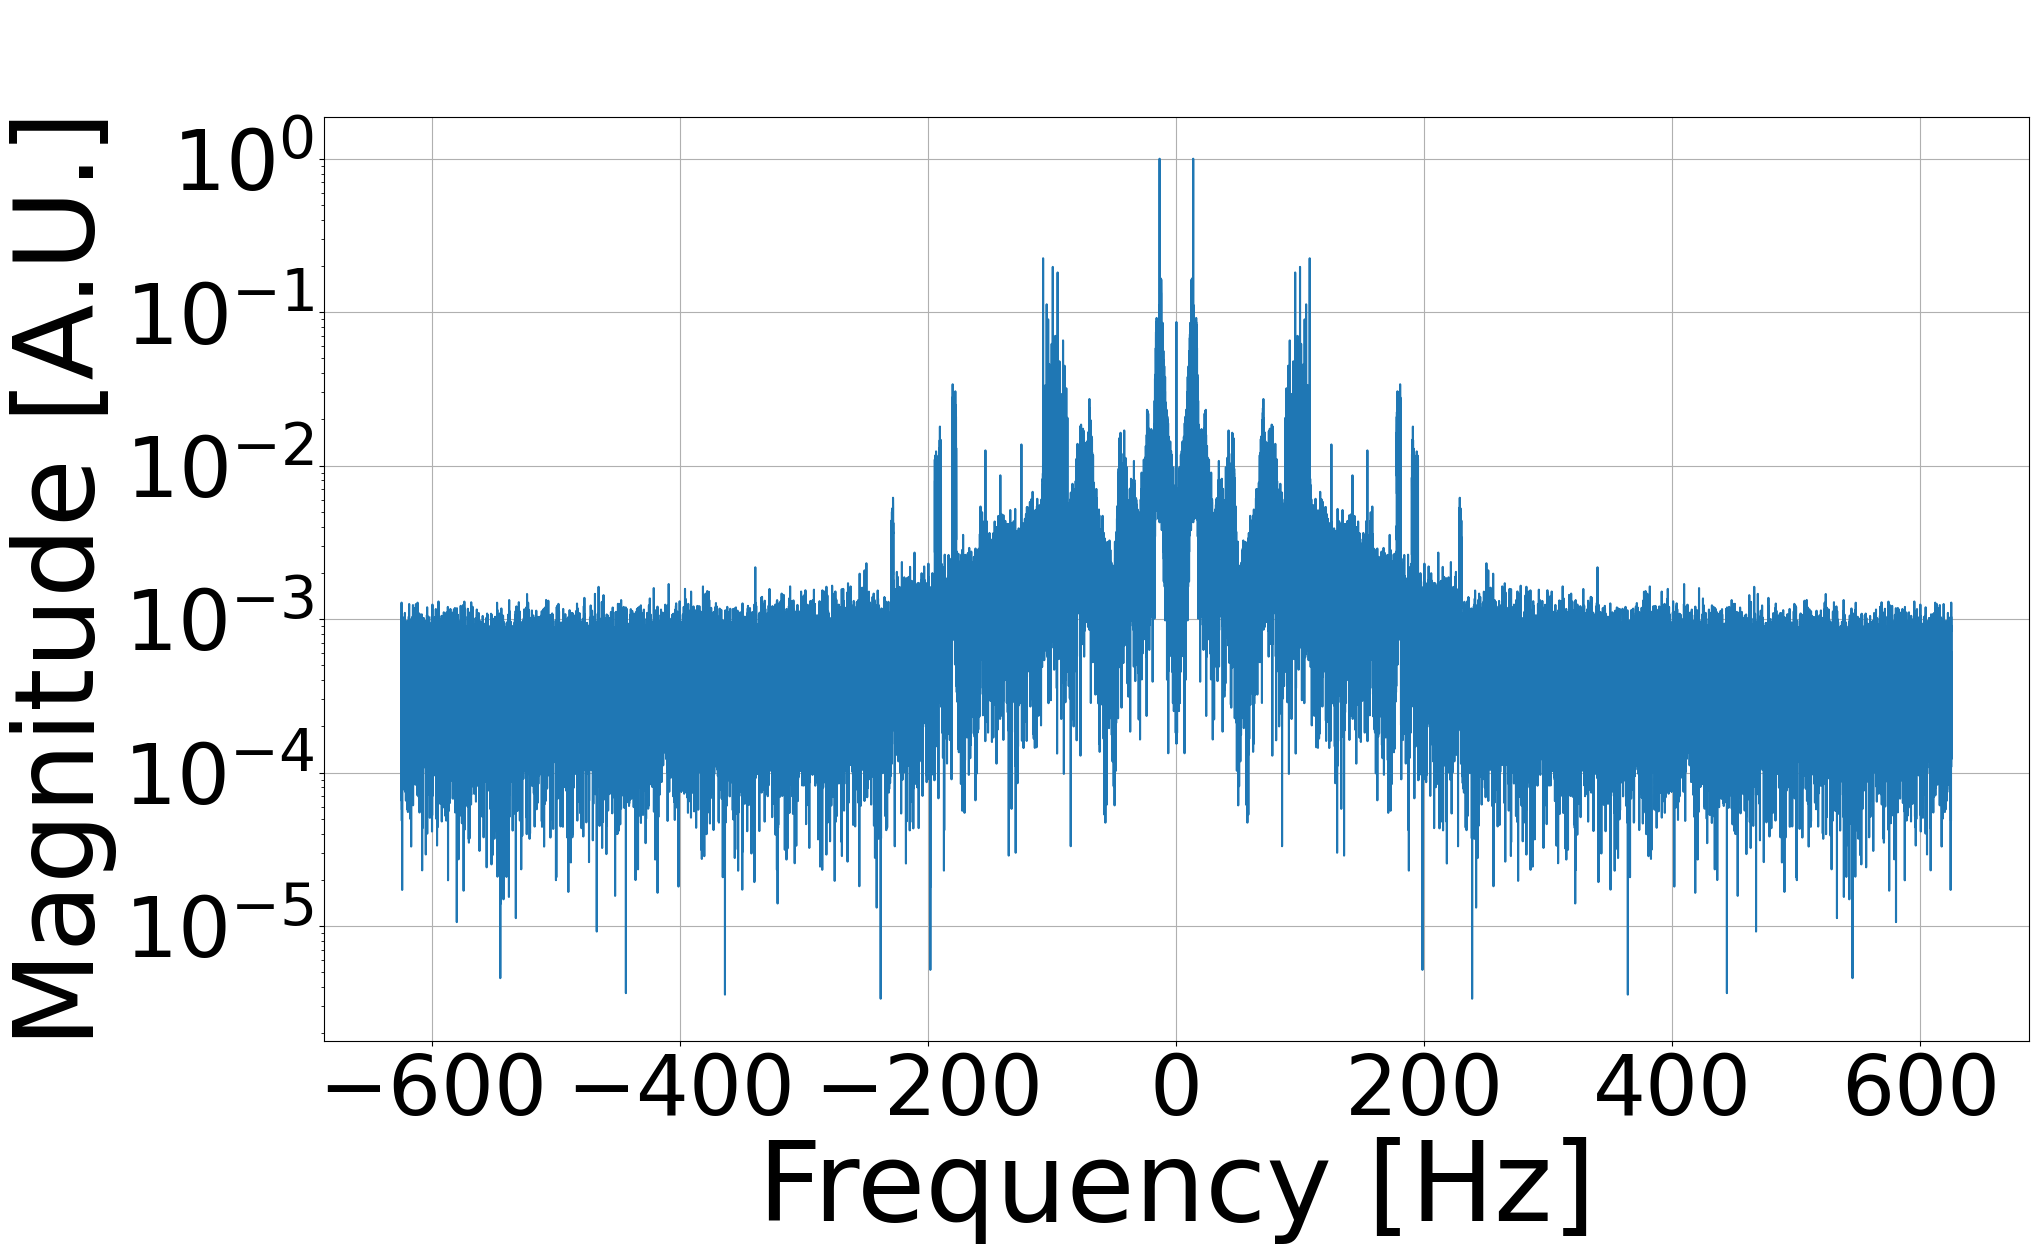

In [31]:
freqs_shifted = fft.fftshift(freqs)
magnitudes_shifted = fft.fftshift(magnitudes)

plt.figure(figsize=(22, 12))
plt.plot(freqs_shifted, np.abs(magnitudes_shifted)/n)
plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [Hz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.semilogy()
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [32]:
if (N%2 == 0):
    pos_freqs = freqs[:round((N/2))]
    pos_magnitudes = magnitudes[:round((N/2))]
    pos_phases = phases[:round((N/2))]
else:
    pos_freqs = freqs[:round((N-1)/2 + 1)]
    pos_magnitudes = magnitudes[:round((N-1)/2 + 1)]
    pos_phases = phases[:round((N-1)/2 + 1)]

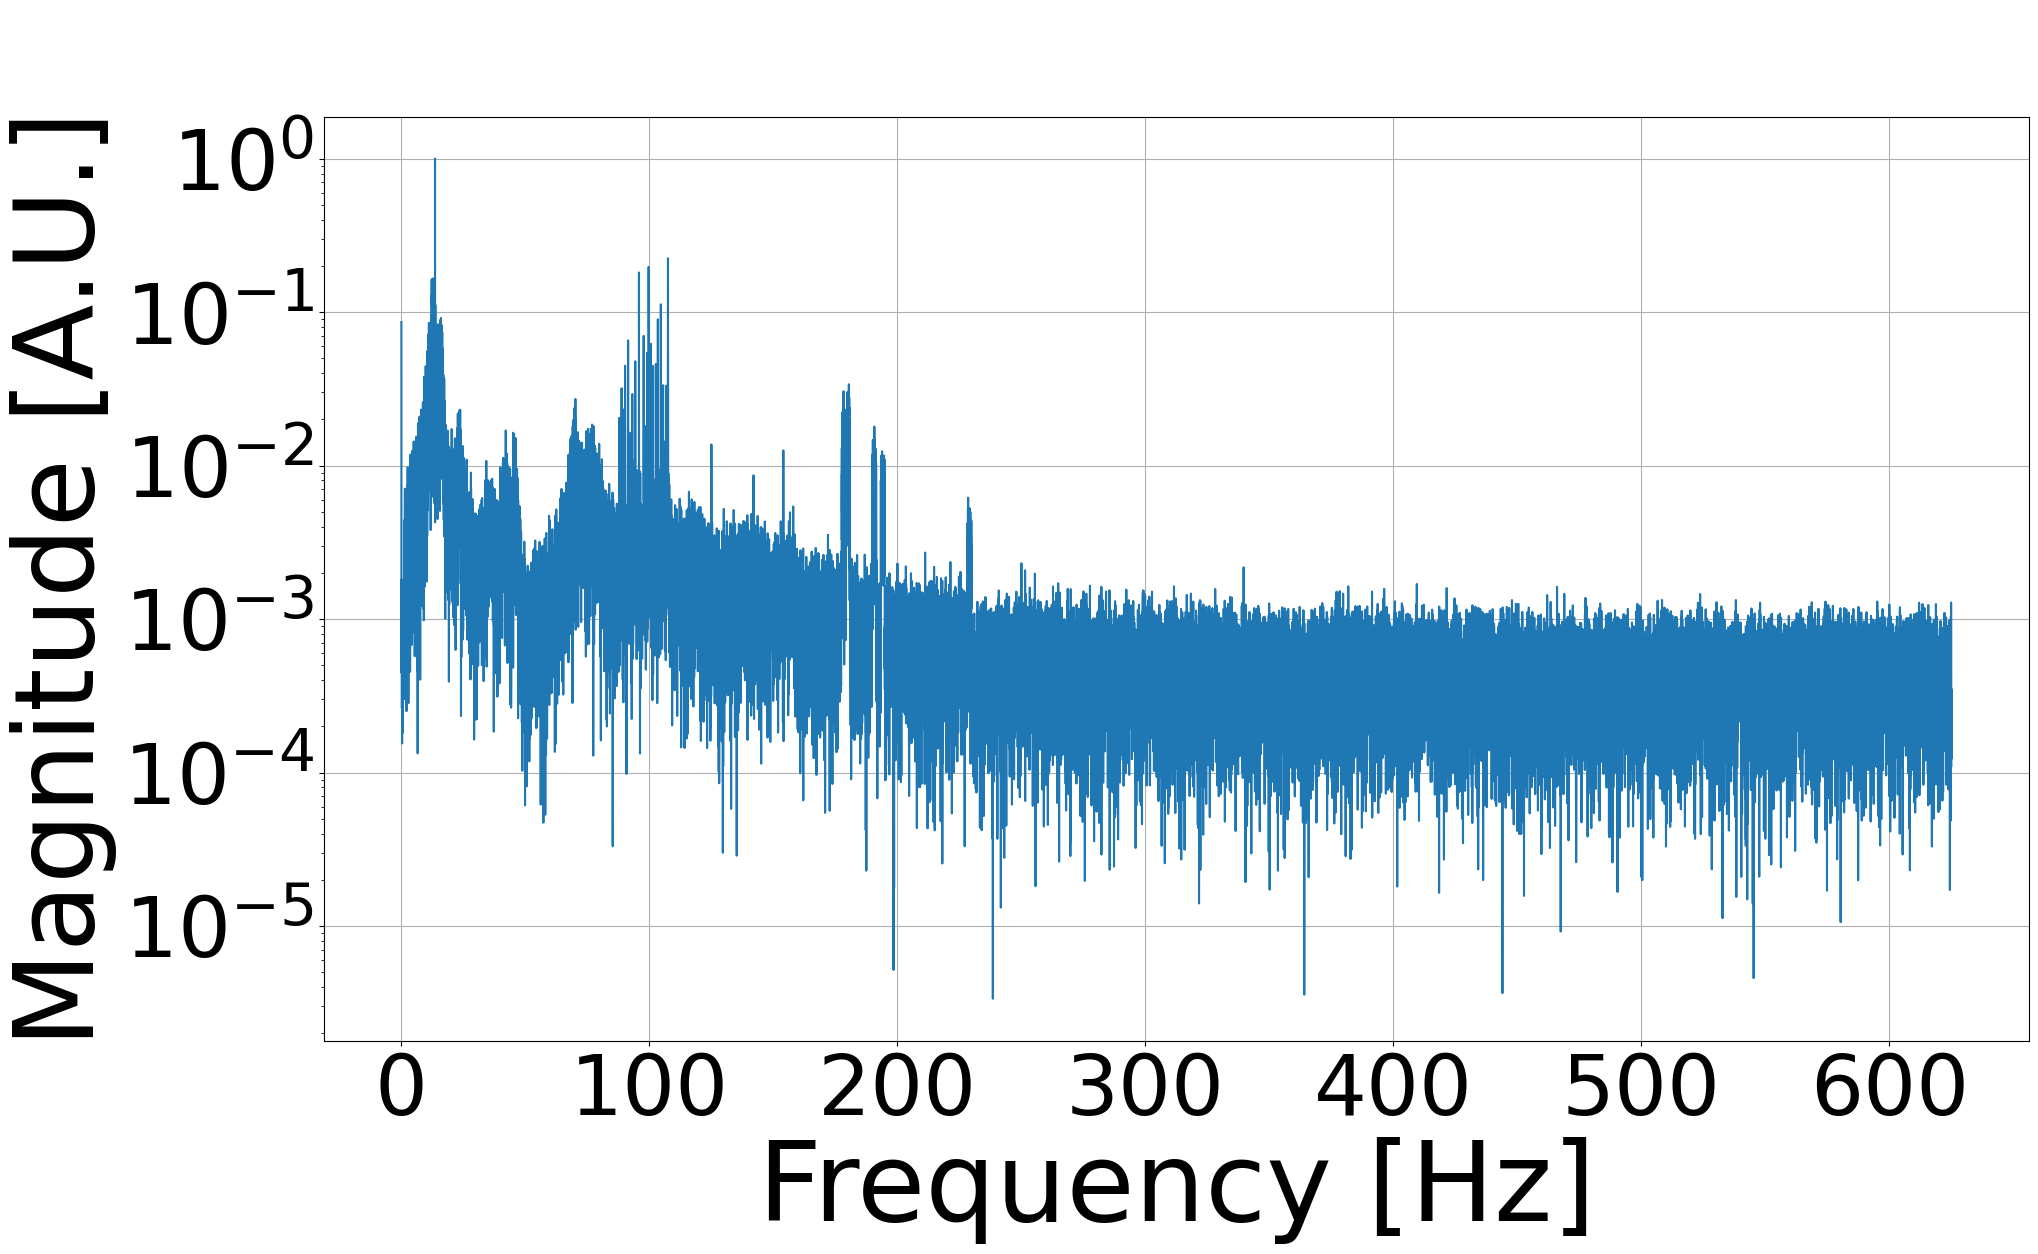

In [34]:
plt.figure(figsize=(22, 12))
plt.plot(pos_freqs, np.abs(pos_magnitudes)/n)

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [Hz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.semilogy()
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

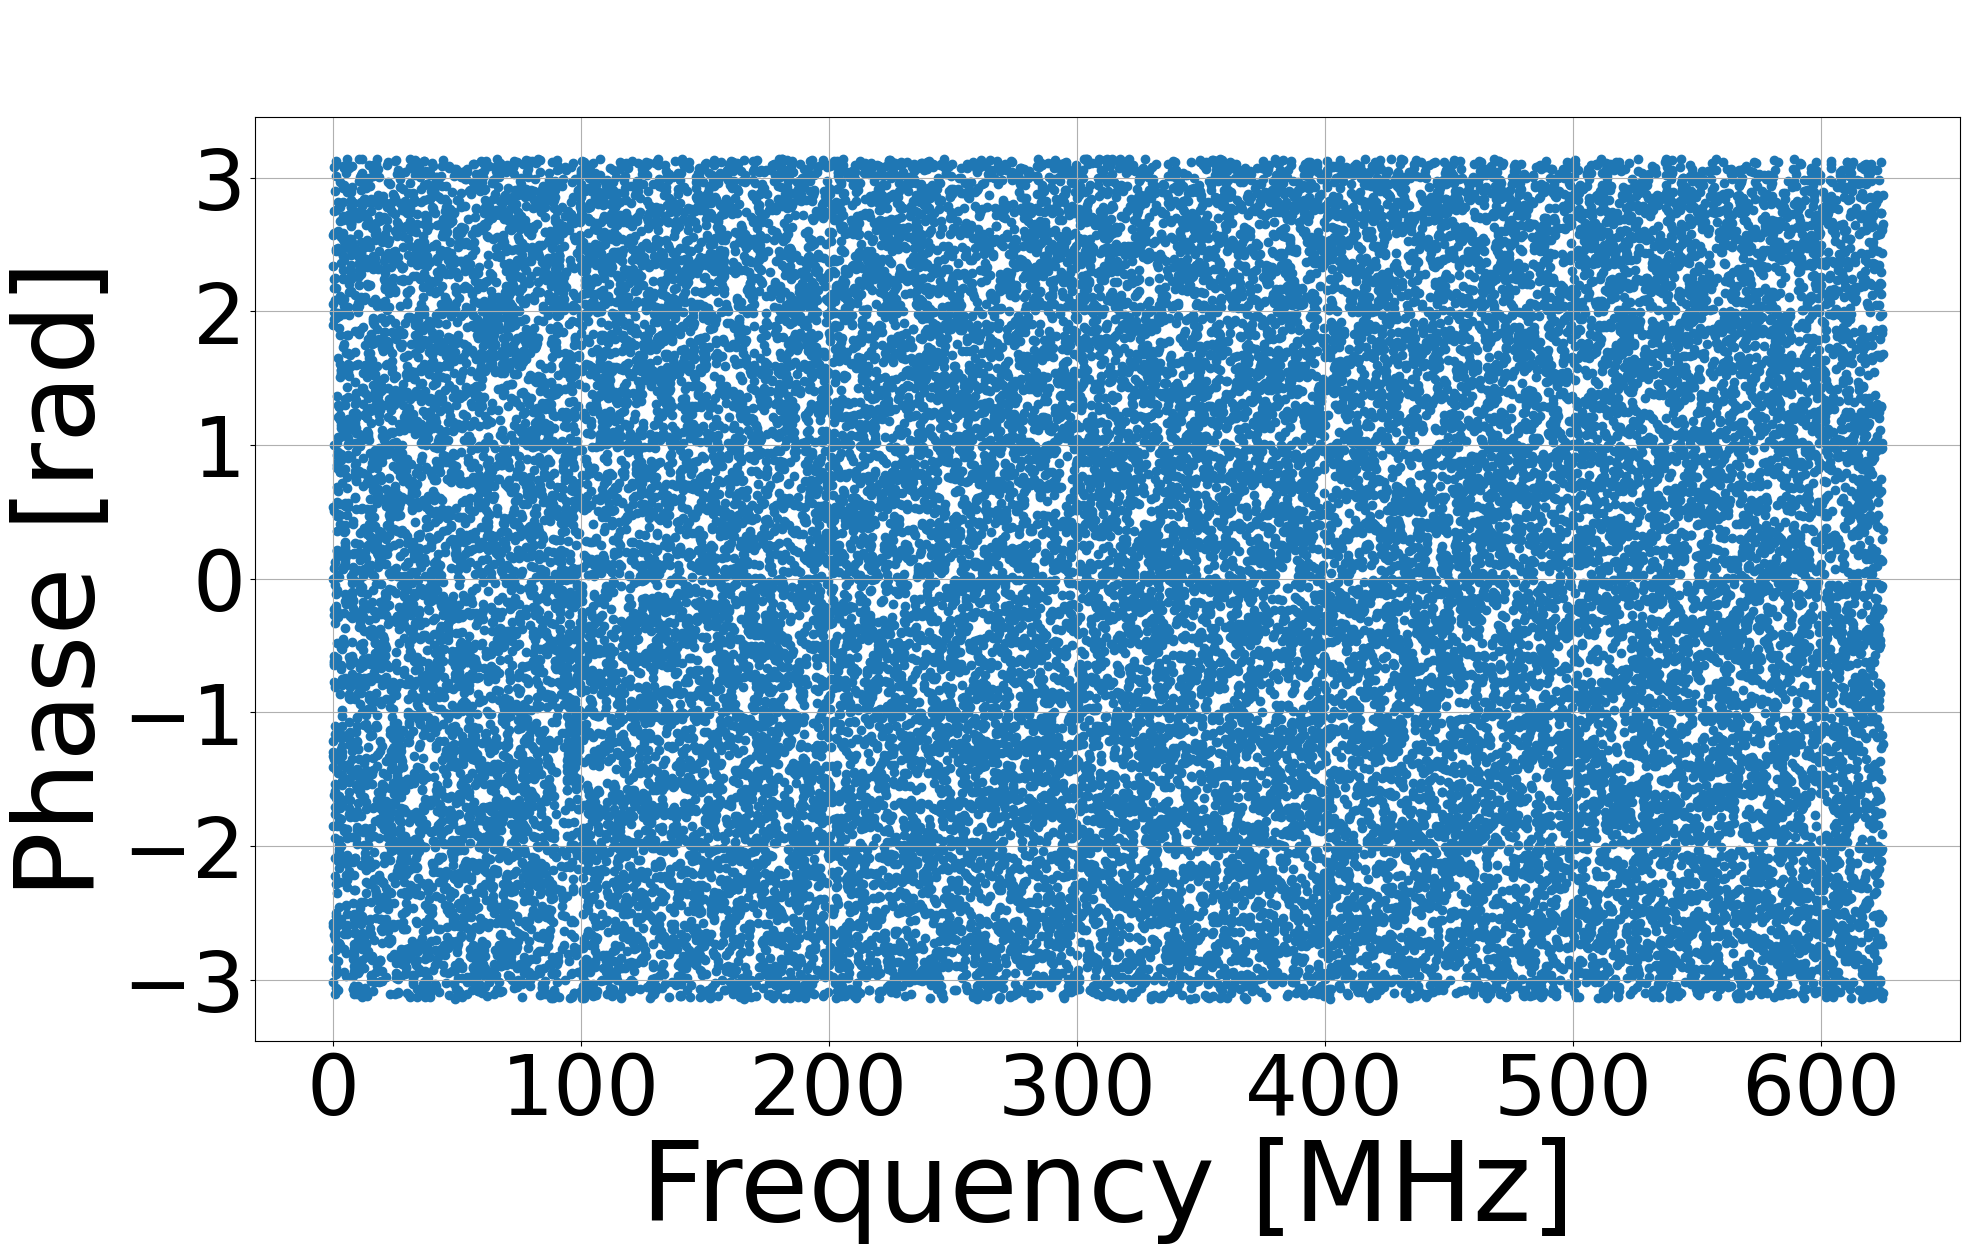

In [36]:
plt.figure(figsize=(22, 12))
plt.scatter(pos_freqs, pos_phases)

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [MHz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Phase [rad]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [12]:
f1 = 13
f2 = 14

In [37]:
print(f"positive peak frequency: {pos_freqs[(pos_freqs >= f1) & (pos_freqs <= f2)][np.argmax(pos_magnitudes[(pos_freqs <= f2) & (pos_freqs >= f1)])]} Hz")
print(f"positive peak phase: {pos_phases[(pos_freqs >= f1) & (pos_freqs <= f2)][np.argmax(pos_magnitudes[(pos_freqs <= f2) & (pos_freqs >= f1)])]*180/np.pi} deg")

positive peak frequency: 13.679343208222809 Hz
positive peak phase: 19.324525707928867 deg


## Filtering

In [13]:
noise_fft, peak_f, peak_phases = filtering_func(freqs, magnitudes, phases, f1, f2)

peak_f: [ 13.55934897 -13.55934897]
peak_phase: [-2.16944597  2.16944597]
sum: 2


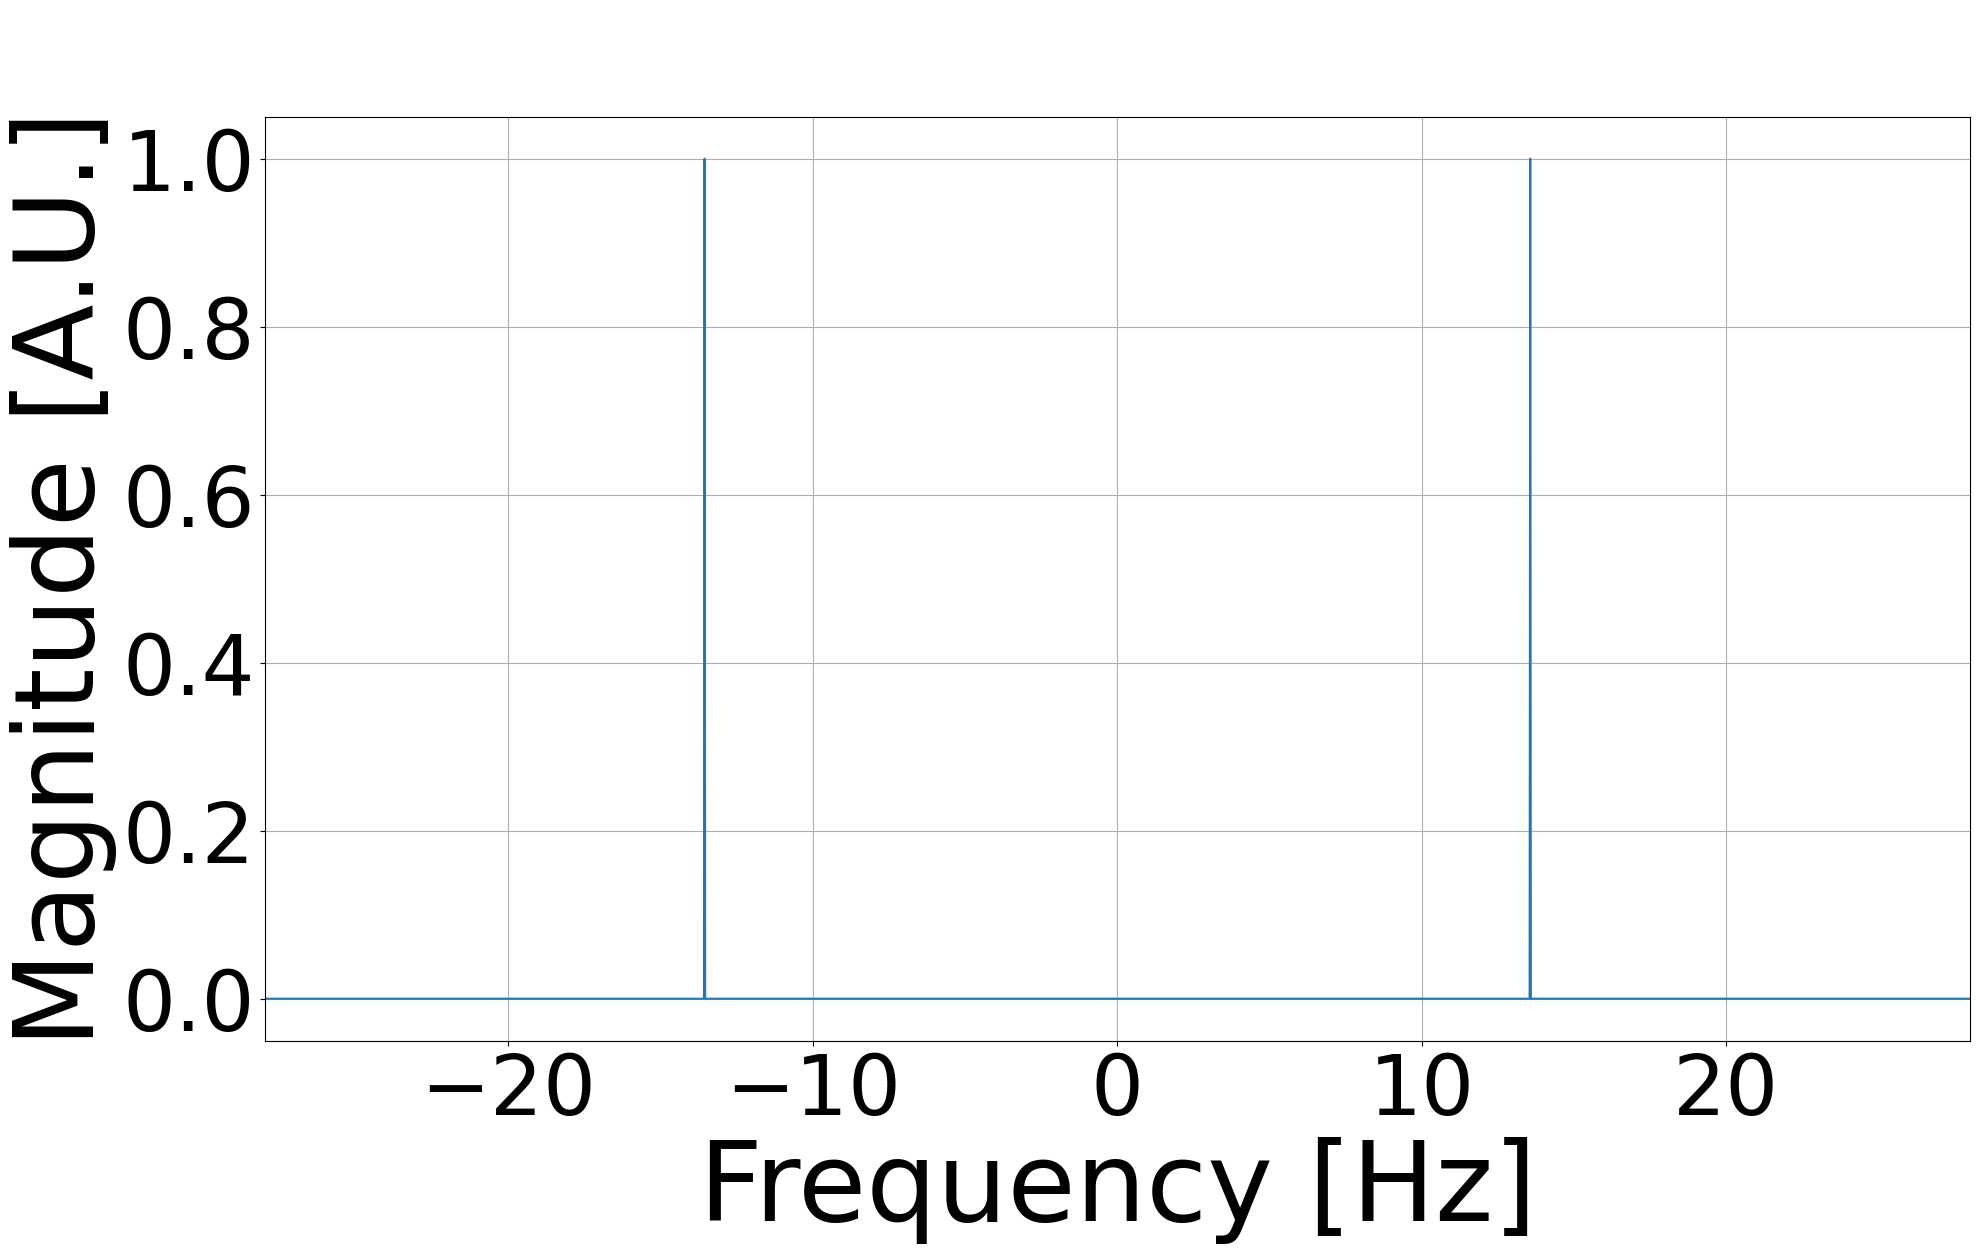

In [62]:
noise_fft_shifted = fft.fftshift(noise_fft)

plt.figure(figsize=(22, 12))
plt.plot(freqs_shifted, np.abs(noise_fft_shifted)/n)

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [Hz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.xlim(-f2*2, f2*2)
plt.grid(True)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()


In [38]:
noise_wf = fft.ifft(noise_fft)

In [39]:
A = max(noise_wf.real)
f = peak_f[0]
phi = peak_phases[0]
coswave = A*np.cos(f*np.pi*2*times + phi)

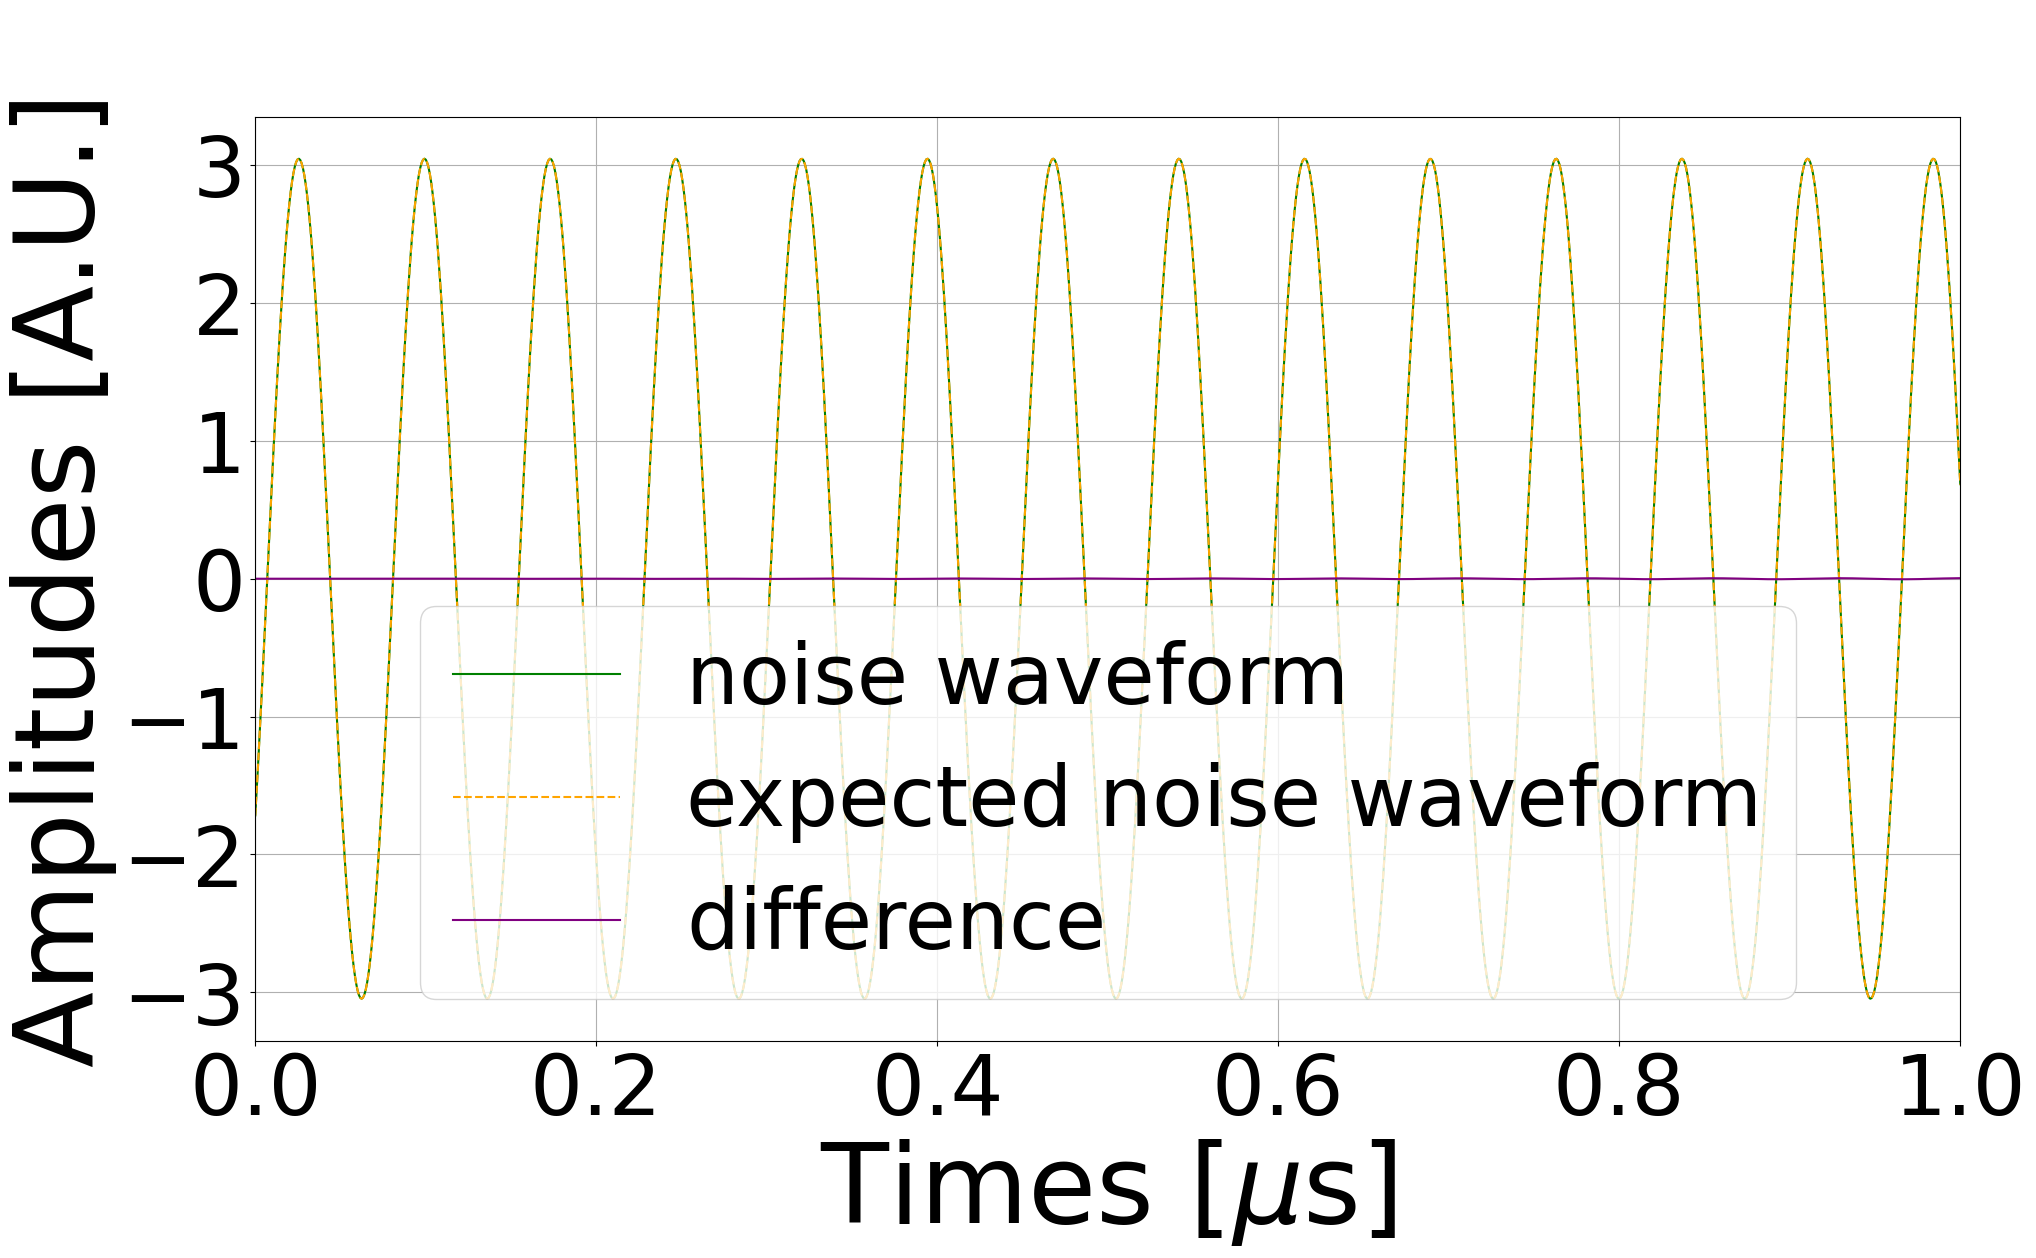

In [64]:
plt.figure(figsize=(22, 12))
plt.plot(times, noise_wf.real, color = 'green', label = 'noise waveform') #you can see that it remembers the phase only if you pass the complex numbers as fft to fft.ifft
plt.plot(times, coswave, linestyle = '--', color = 'orange', label = 'expected noise waveform')
plt.plot(times, noise_wf.real - coswave, color = 'purple', label = 'difference')

plt.title(' ', fontsize = 80)
plt.xlabel(r'Times [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitudes [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'lower center', fontsize = 60)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [43]:
print(np.arccos((noise_wf.real)[times == 0]/A)*180/np.pi)
print(np.arccos((coswave)[times == 0]/A)*180/np.pi)

[124.30009824]
[124.30009813]


## Compare to original waveform

In [19]:
reconstructed_wf = fft.ifft(magnitudes)

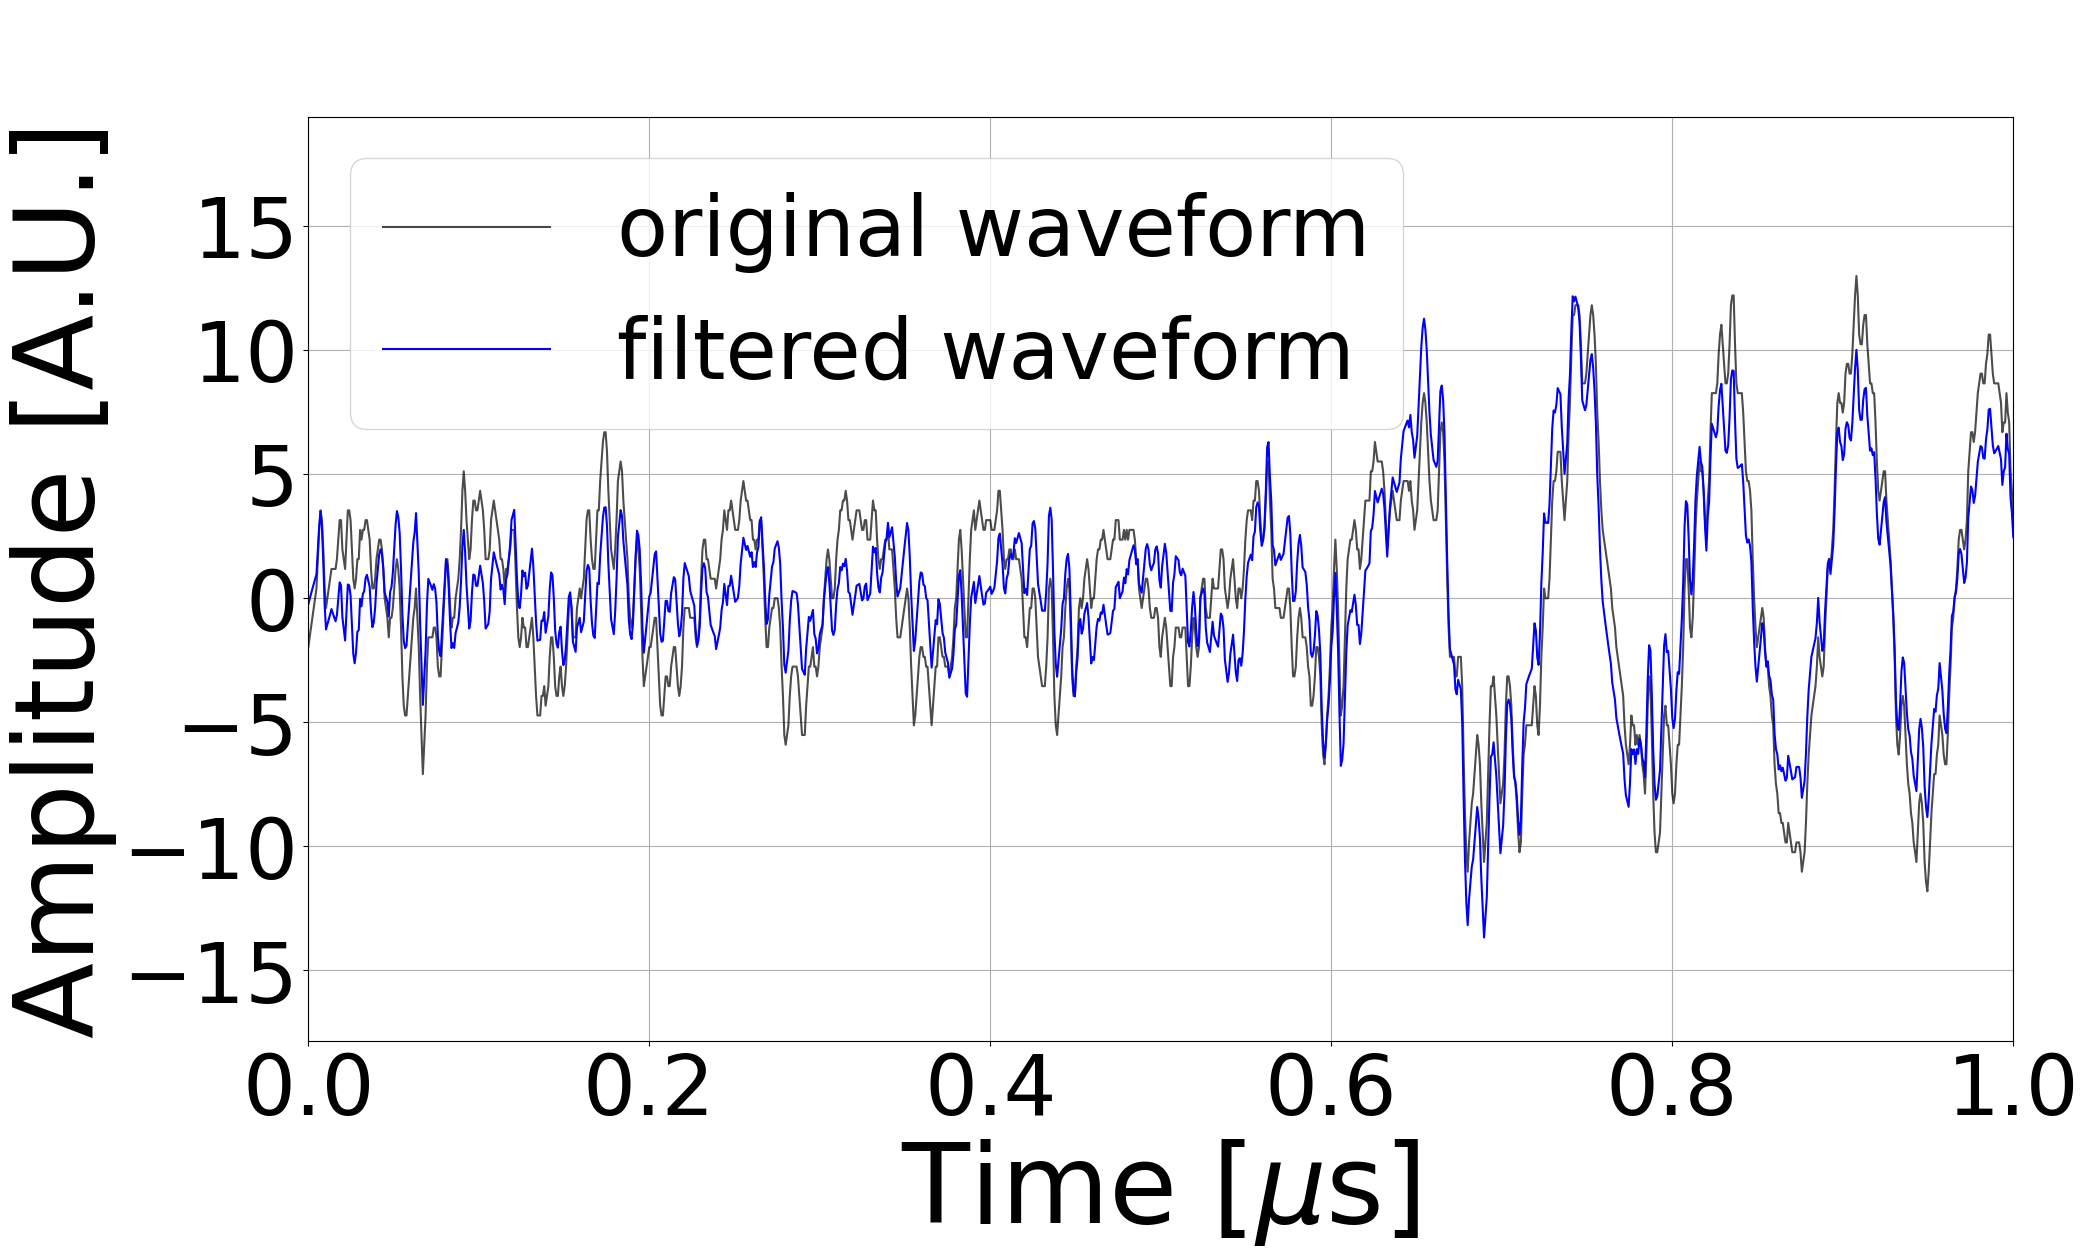

In [44]:
plt.figure(figsize = (22, 12))
plt.plot(times, reconstructed_wf.real, label = 'original waveform', color = 'black', alpha = 0.7)
plt.plot(times, reconstructed_wf.real - noise_wf.real, label = 'filtered waveform', color = 'blue')
plt.title(' ', fontsize = 80)
plt.xlabel(r'Time [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 60)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

# Make sure reconstructed waveform and original waveform are the same

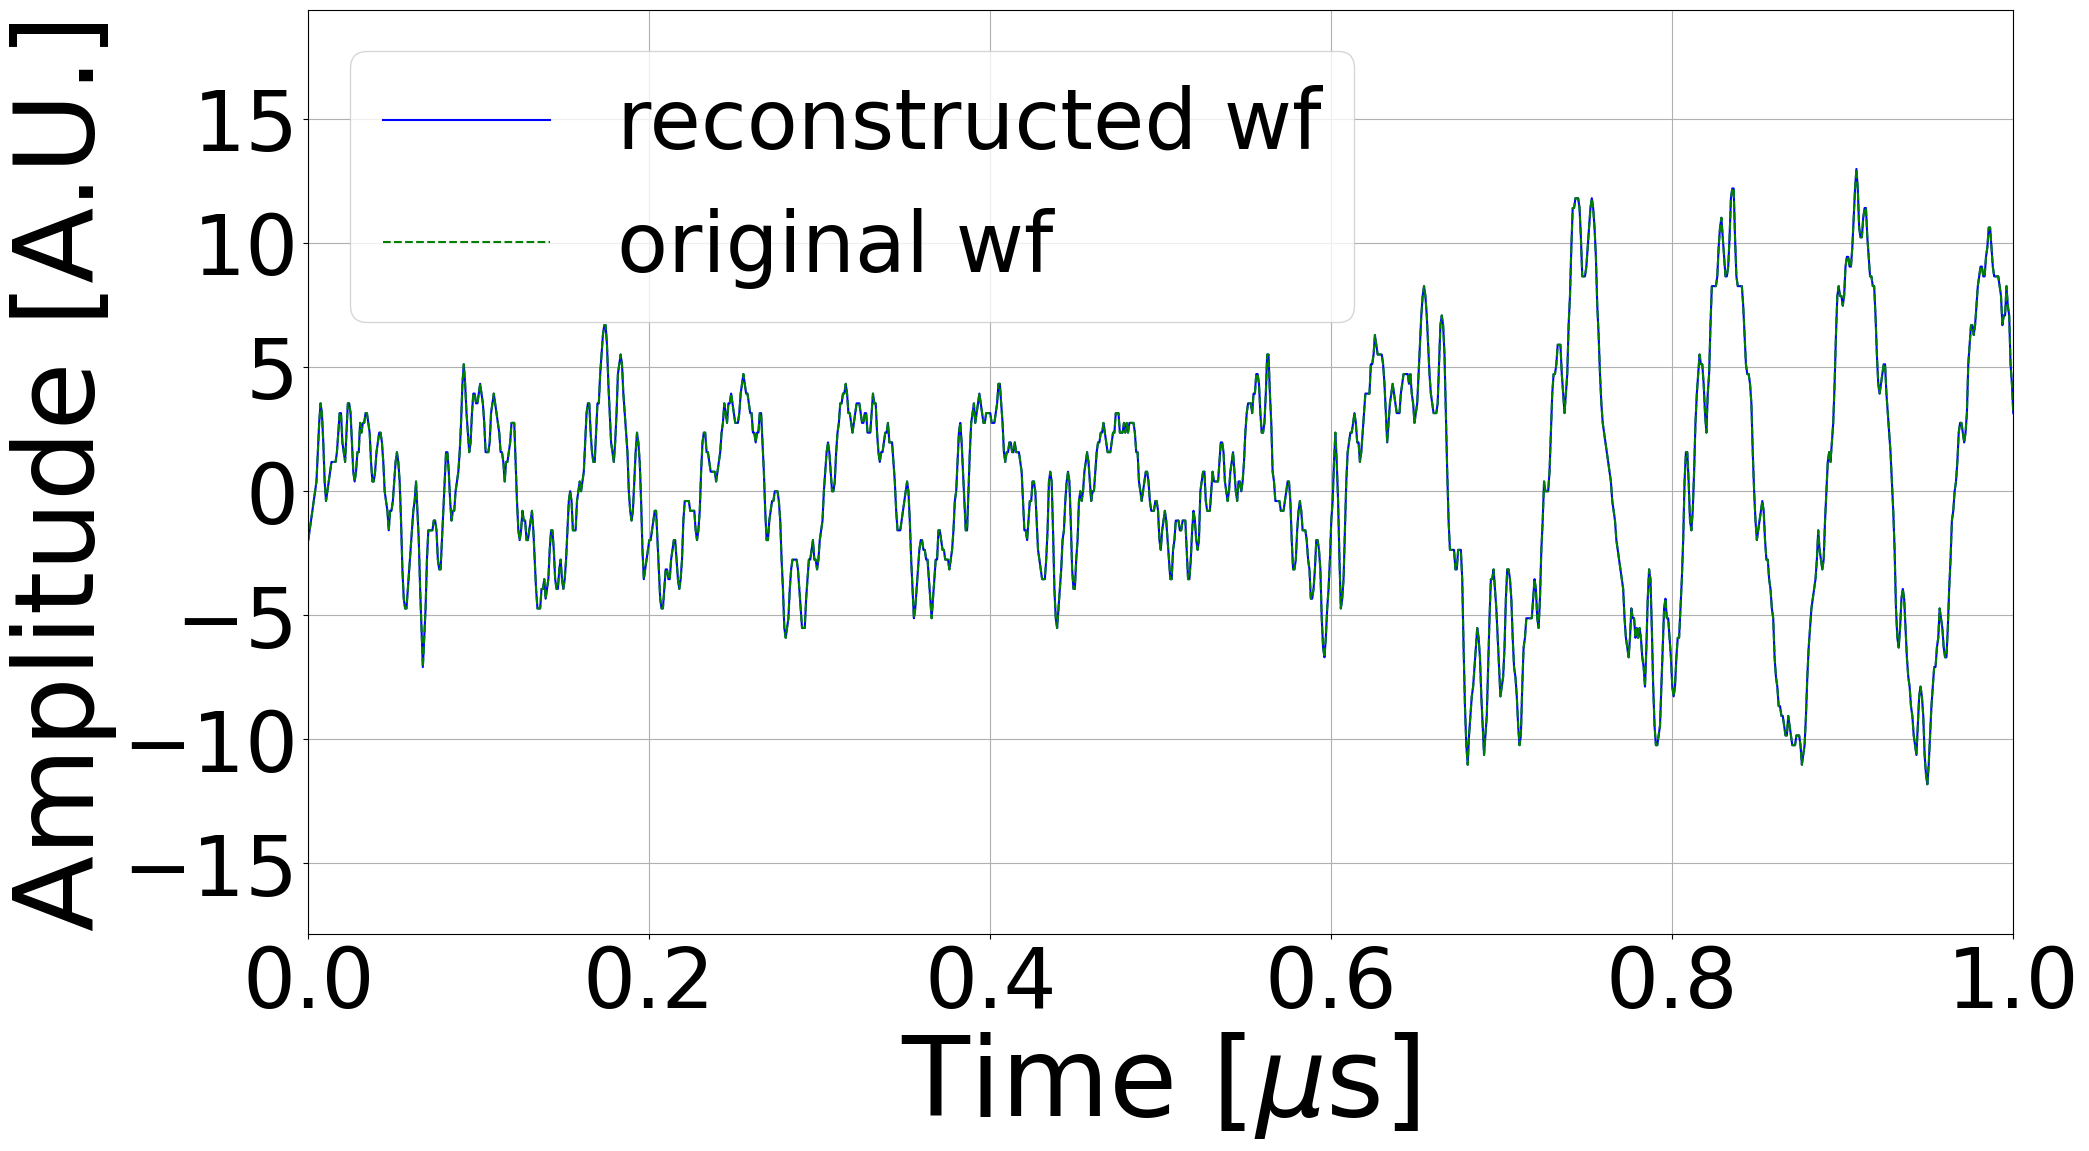

In [46]:
plt.figure(figsize = (22, 12))
plt.plot(times, reconstructed_wf.real, label = 'reconstructed wf', color = 'blue') #why real?
plt.plot(times, amplitudes, label = 'original wf', color = 'green', linestyle = '--')

plt.title('', fontsize = 80)
plt.xlabel(r'Time [$\mu$s]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Amplitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, 1)
plt.legend(loc = 'best', fontsize = 60)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

# Plot reconstructed FFT

In [22]:
reconstructed_filtered_wf = reconstructed_wf - noise_wf
reconstructed_filtered_fft = fft.fft(reconstructed_filtered_wf)

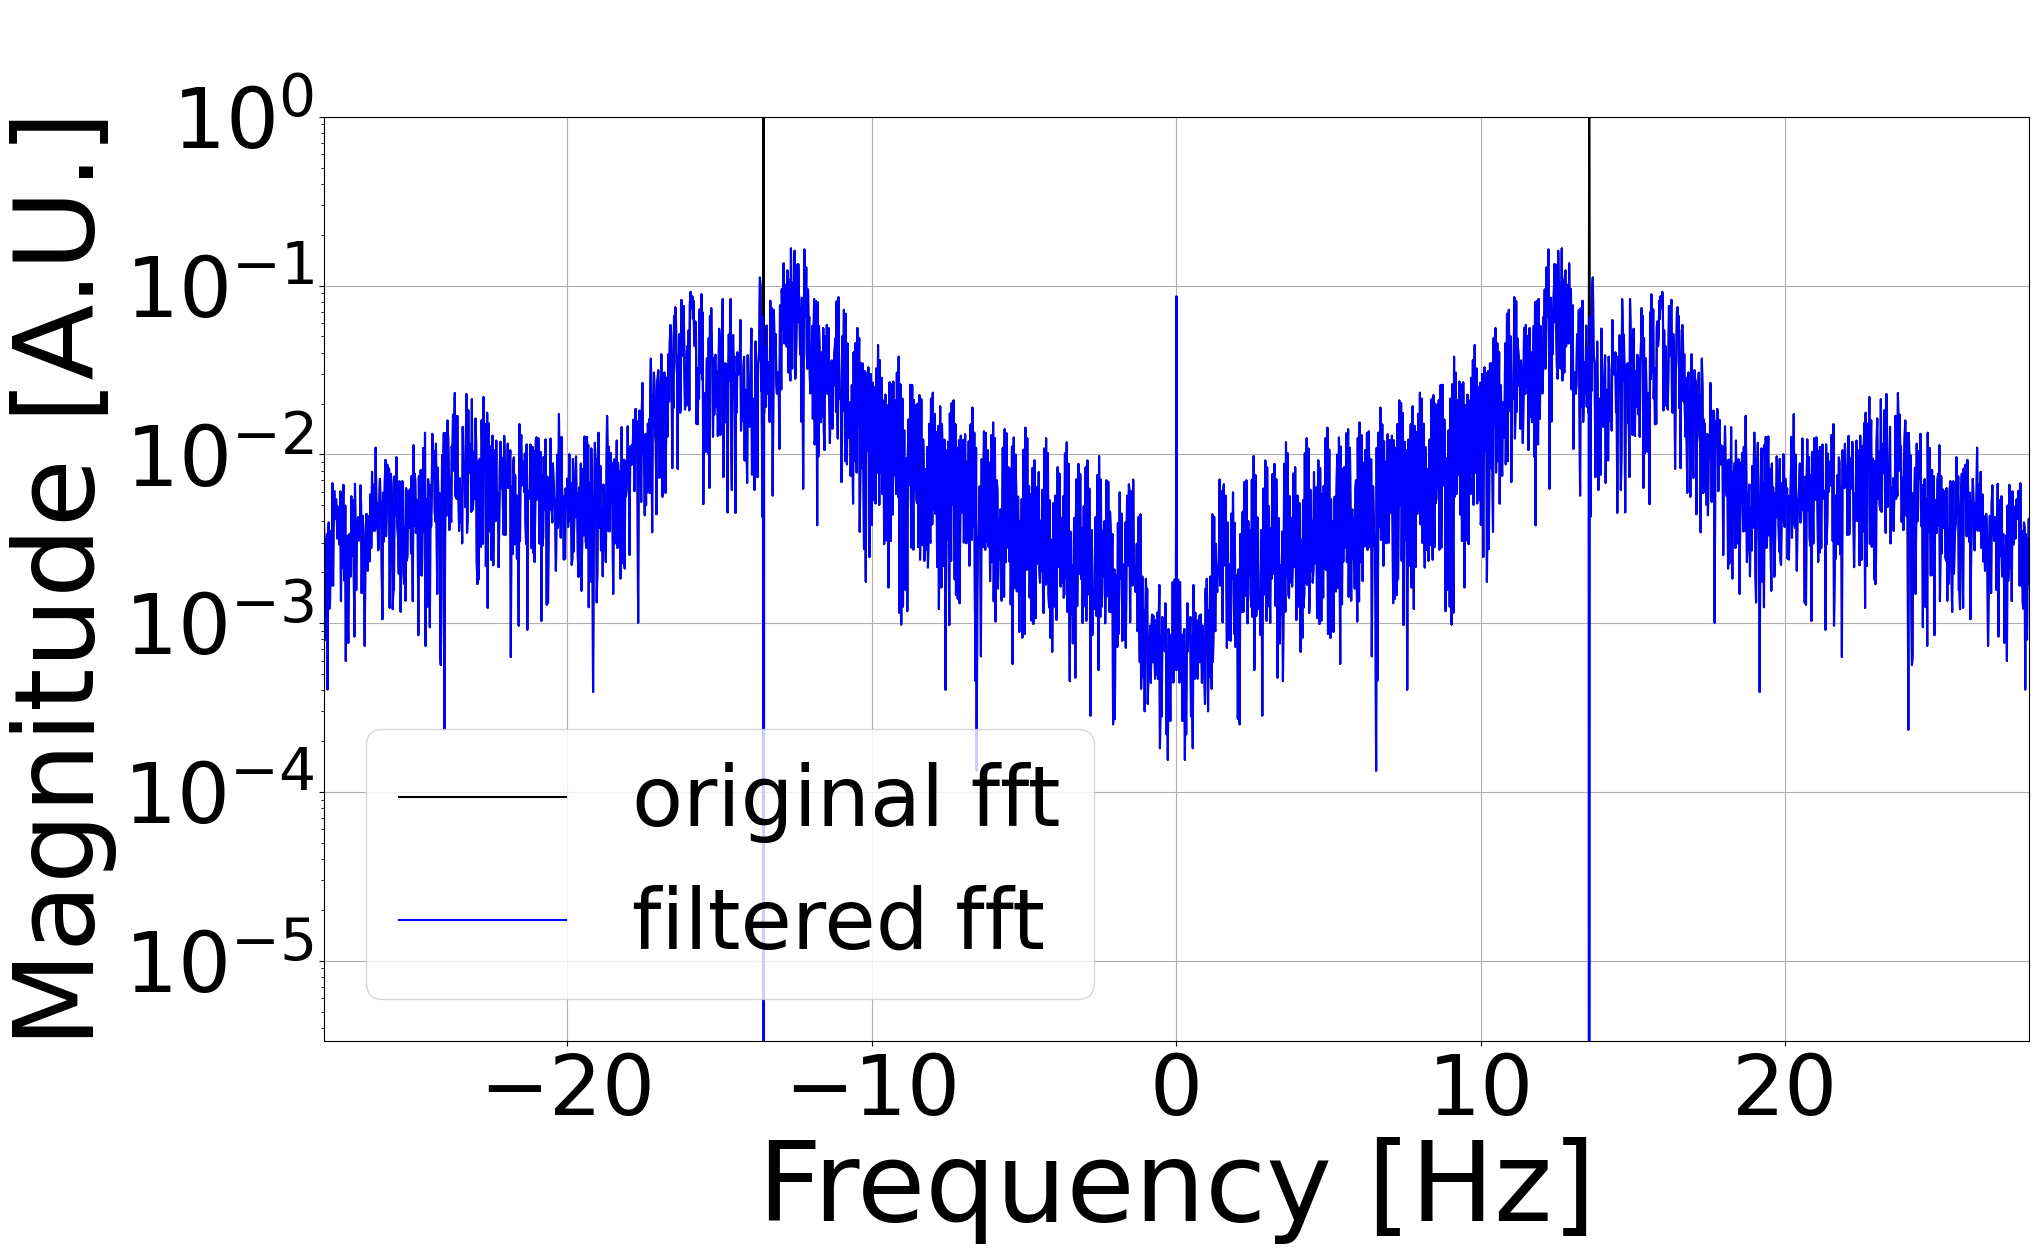

In [52]:
reconstructed_filtered_fft_shifted = fft.fftshift(reconstructed_filtered_fft)

plt.figure(figsize=(22, 12))
plt.plot(freqs_shifted, np.abs(magnitudes_shifted)/n, color = 'k', label = 'original fft')
plt.plot(freqs_shifted, np.abs(reconstructed_filtered_fft_shifted)/n, color = 'blue', label = 'reconstructed filtered fft')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [Hz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.semilogy()
plt.ylim([min(np.abs(magnitudes_shifted)/n), max(np.abs(magnitudes_shifted)/n)])  # Adjust the y-axis range
plt.xlim(-f2*2, f2*2)
plt.grid(True)
plt.legend(loc = 'lower left',fontsize = 60)

#plt.savefig("Results/simple_fft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [53]:
if (N%2 == 0):
    pos_reconstructed_filtered_fft = reconstructed_filtered_fft[:round((N/2))]
else:
    pos_reconstructed_filtered_fft = reconstructed_filtered_fft[:round((N-1)/2 + 1)]

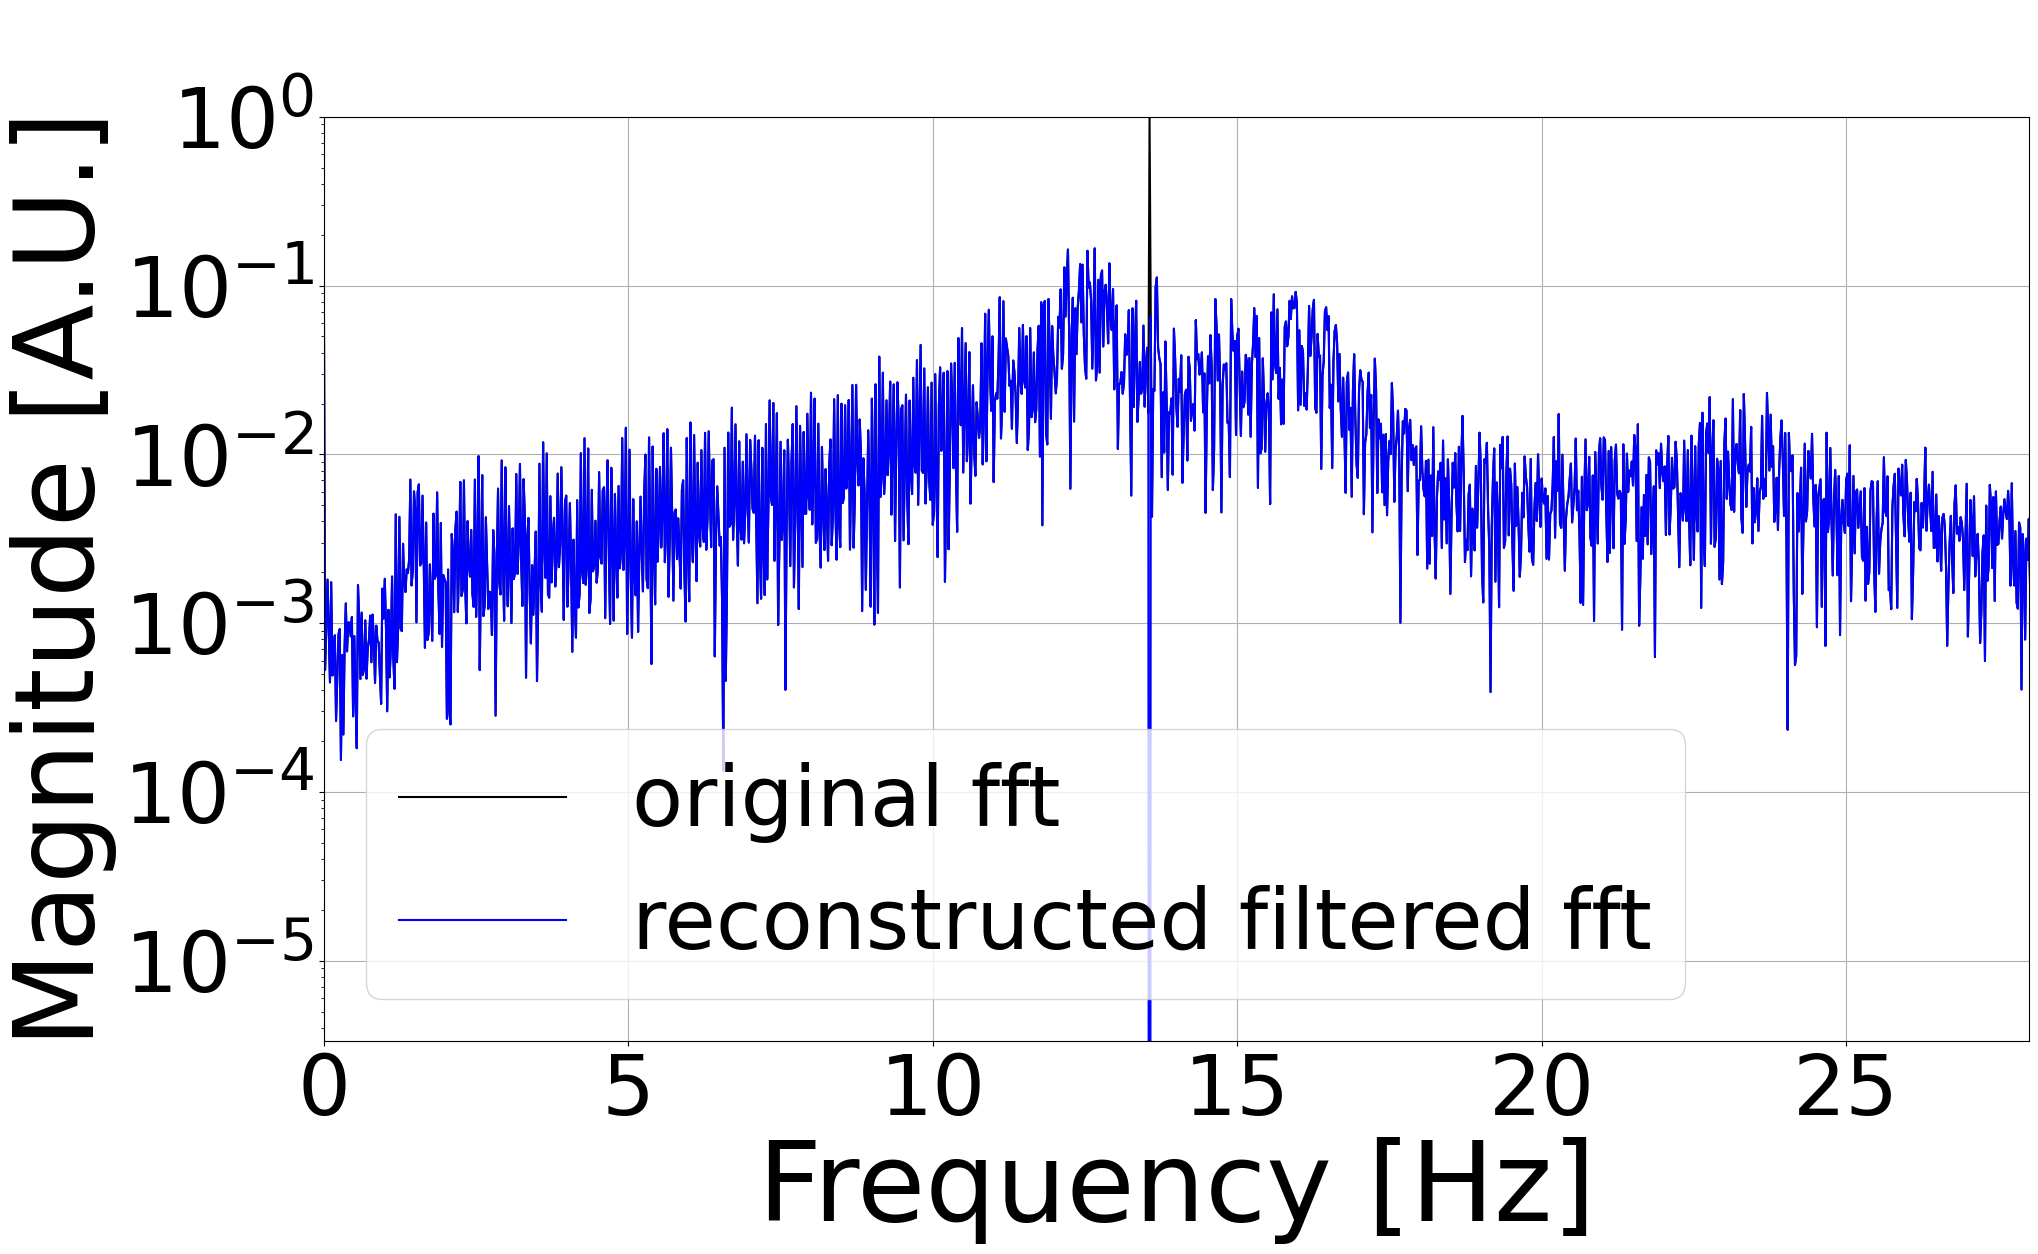

In [66]:
plt.figure(figsize=(22, 12))
plt.plot(pos_freqs, np.abs(pos_magnitudes)/n, color = 'k', label = 'original fft')
plt.plot(pos_freqs, np.abs(pos_reconstructed_filtered_fft)/n, color = 'blue', label = 'reconstructed filtered fft')

plt.title(' ', fontsize = 80)
plt.xlabel('Frequency [Hz]', fontsize = 80)
plt.xticks(fontsize = 60)
plt.ylabel('Magnitude [A.U.]', fontsize = 80)
plt.yticks(fontsize = 60)
plt.grid(True)
plt.xlim(0, f2*2)
plt.ylim([min(np.abs(magnitudes_shifted)/n), max(np.abs(magnitudes_shifted)/n)])  # Adjust the y-axis range
plt.legend(loc = 'lower left', fontsize = 60)
plt.semilogy()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()